In [1]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
num_epochs = 50
batch_size = 1
learning_rate = 0.001

input_size = 222
sequence_length = 4
hidden_size = 128
num_layers = 2

In [3]:
initialize=True

In [4]:
df = pd.read_csv('../data/united_data.csv', index_col=0).fillna(0)
y = df['Corn_Yield']
X = df.drop(columns=['Corn_Yield'], axis=1)

In [5]:
y = pd.DataFrame(y)
def convert_corn_yield(row):
    idx = row.name
    year = int(idx[:4])
    row['Corn_Yield'] = row['Corn_Yield'] + (1950-year)*1.96966271
    return row
    

In [6]:
y = y.apply(convert_corn_yield, axis=1)
y = y['Corn_Yield']

In [7]:
class MyDataset(Dataset):
 
  def __init__(self,X,y):
    self.x_train=torch.tensor(X,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.float32)
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

In [9]:
train_data=MyDataset(X_train.to_numpy(), y_train.to_numpy())
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=False)

test_data=MyDataset(X_test.to_numpy(), y_test.to_numpy())
train_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [10]:
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)


In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        if initialize:
            h0 = torch.zeros(num_layers, x.size(0), hidden_size)
            c0 = torch.zeros(num_layers, x.size(0), hidden_size)
            x, _ = self.lstm(x,(h0,c0))
        else:
            x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [12]:
model = LSTM(input_size, hidden_size, num_layers)
weather_test = X_test.reshape(-1, sequence_length, input_size)
weather_train = X_train.reshape(-1, sequence_length, input_size)
print(weather_test.shape)
print(weather_train.shape)

torch.Size([363, 4, 222])
torch.Size([1086, 4, 222])


## Train the model

In [13]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
n_total_steps = len(train_loader)
train_losses = []
test_losses = []
min_test_loss = 9999999
for epoch in range(num_epochs):
    for i, (weather, labels) in enumerate(train_loader):  
        weather = weather.reshape(-1, sequence_length, input_size)
        
        # Forward pass
        outputs = model(weather)
        loss = criterion(outputs.reshape(-1), labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#         if (i+1) % 100 == 0:
#             print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    if (epoch + 1) % 1 == 0:
        with torch.no_grad():
            outputs = model(weather_train)
            loss_train = criterion(outputs.reshape(-1), y_train)
            outputs = model(weather_test)
            loss_test = criterion(outputs.reshape(-1), y_test)
            train_losses.append(loss_train)
            test_losses.append(loss_test)
            if loss_test < min_test_loss:
                torch.save(model.state_dict(), "best")
            print("Epoch: ", epoch + 1, " Train loss: ", loss_train.item(), "Test loss:", loss_test.item())

Epoch:  1  Train loss:  764.3579711914062 Test loss: 721.2215576171875
Epoch:  2  Train loss:  743.3907470703125 Test loss: 706.3042602539062
Epoch:  3  Train loss:  709.6259155273438 Test loss: 680.6423950195312
Epoch:  4  Train loss:  673.9205932617188 Test loss: 645.74365234375
Epoch:  5  Train loss:  561.3590087890625 Test loss: 520.4384155273438
Epoch:  6  Train loss:  525.7589111328125 Test loss: 472.14398193359375
Epoch:  7  Train loss:  523.824951171875 Test loss: 453.535888671875
Epoch:  8  Train loss:  553.0527954101562 Test loss: 515.39697265625
Epoch:  9  Train loss:  507.9464111328125 Test loss: 443.3236389160156
Epoch:  10  Train loss:  498.33746337890625 Test loss: 422.4346008300781
Epoch:  11  Train loss:  496.9972839355469 Test loss: 402.0808410644531
Epoch:  12  Train loss:  461.82305908203125 Test loss: 362.4781799316406
Epoch:  13  Train loss:  479.3536071777344 Test loss: 375.3512878417969
Epoch:  14  Train loss:  477.27423095703125 Test loss: 379.11248779296875
Ep

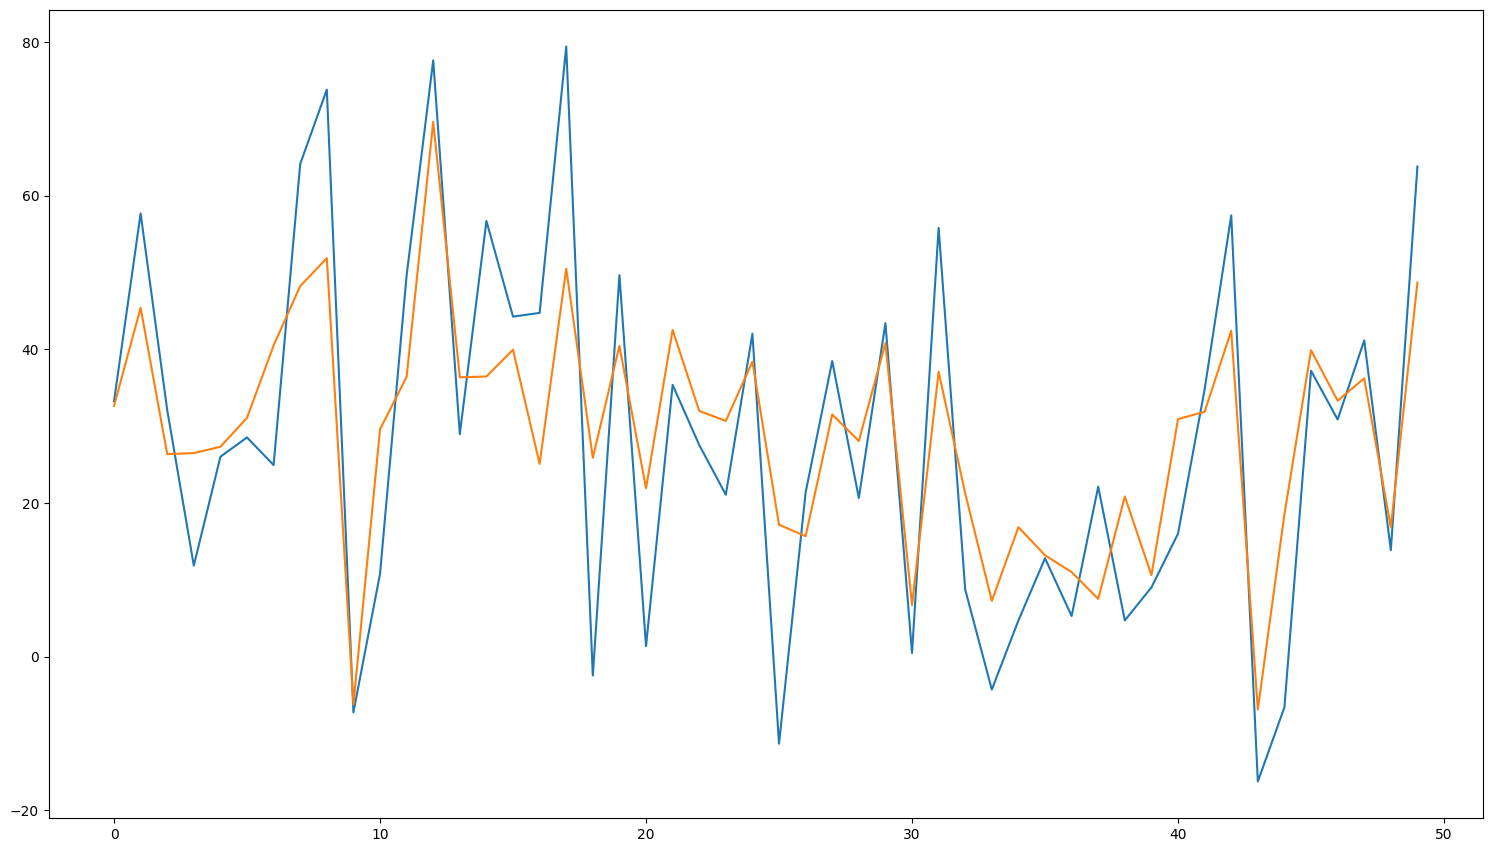

In [14]:
plt.plot(y_test[:50])
plt.plot(outputs[:50].detach())
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

### Load and evaluate the model

In [44]:
from utils import get_data_pred

model.load_state_dict(torch.load("best"))
out = get_data_pred('ACAvNTuEuFWcmwms', model, adjust=True)
out

tensor([[131.6211],
        [116.4029],
        [137.9544],
        [135.1496],
        [157.1388],
        [128.8053],
        [168.0621],
        [131.4076],
        [137.8997],
        [158.2266],
        [153.0342],
        [155.7094],
        [152.9619],
        [162.9537],
        [158.7282],
        [145.9167],
        [146.8170]])

In [222]:
# outputs # of the model we trained without the adjustments

tensor([[100.2934],
        [ 96.1967],
        [ 95.1817],
        [112.0884],
        [ 98.1280],
        [ 88.9596],
        [156.1279],
        [137.4307],
        [ 74.4149],
        [108.9806],
        [119.3128],
        [126.0991],
        [127.9114],
        [104.2989],
        [106.2627],
        [154.4127],
        [ 77.3407]], grad_fn=<AddmmBackward0>)

In [16]:
out # oof the model we trained with the adjustments

tensor([[114.4748],
        [ 63.8450],
        [124.6391],
        [138.7735],
        [141.8226],
        [141.1663],
        [148.0757],
        [131.5047],
        [132.3883],
        [155.8086],
        [149.0855],
        [144.8992],
        [136.4871],
        [154.3260],
        [161.6747],
        [110.9454],
        [144.0197]])

### Plot the loss

In [15]:
res = pd.DataFrame(data=np.asarray([train_losses, test_losses])).transpose()
res.columns = ['Train loss','Test loss']

<Axes: >

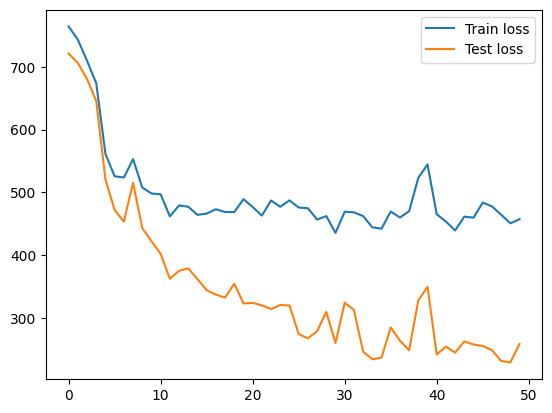

In [16]:
res.plot()

<Axes: >

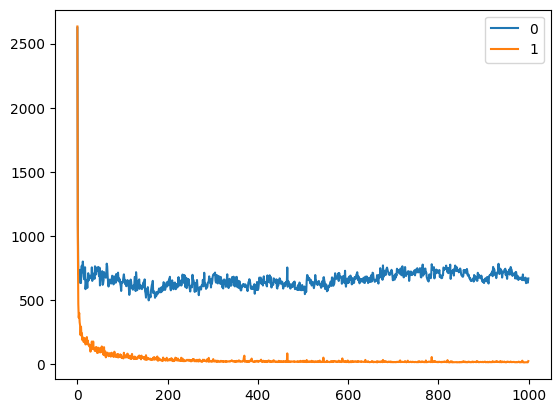

In [72]:
# res.plot() # training without adjustments 